### 1. Load Raw Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MotionData as m
%matplotlib inline

#use the MotionData class to load motion data and clear data
motionLoader = m.MotionData('data')
motion = motionLoader.motion
valid_questionnaire = motionLoader.qs

#Join valid users from questionnaire with motion dataframe...effectively removing users from the motion dataframe that do not have valid questionnaire data
motion = pd.merge(valid_questionnaire[['user']],motion,on='user',how='left')

### 2. Motion File Processing:

##### 2.1 Users that have uploaded less than 40 hours of movement data (40 hours when phone was not stationary) will be removed
##### f2-28 features will be NAN for hours where NO movement occured (details <a href="featureDescriptions.md">here</a>). We use f2 the count hours of non-NAN values

In [4]:
#Count number of f2 features for each user....using f2 as we want to count number of hours where there was activity. If f2 is NAN then there was no activity
NUM_ACTIVE_DAYS_NEEDED = 5
entryCounts = motion.groupby(by='user').count()[['f2']]
#select users with at least 40 hours of non-stationary motion data
validmotion_Users= entryCounts[entryCounts['f2'] > 8 * NUM_ACTIVE_DAYS_NEEDED].reset_index()
print(f"Motion file has {validmotion_Users.shape[0]} users with at least {8 * NUM_ACTIVE_DAYS_NEEDED} hours of active motion data")


Motion file has 307 users with at least 40 hours of active motion data


#### 2.2 Left join valid user with full motion file...in effect this will remove non valid users from the motion dataframe


In [5]:
validmotion = pd.merge(validmotion_Users['user'],motion,on='user',how='left')

#### 2.3 Group motion file by user and by day....allowing us to compute summary features of motion per day for each user

In [6]:
validmotion['day'] = validmotion['datetime'].dt.date

dailyMotionAggs = validmotion.drop('datetime',axis=1).groupby(by=['user','day']).agg(['mean','min','max','std','median','skew'])

# get rid of multi level column names and change to single flat column names which combines level0 and level1 naming
flatCols = dailyMotionAggs.columns.get_level_values(0) + '_' +  dailyMotionAggs.columns.get_level_values(1)
dailyMotionAggs.columns = flatCols

#### 2.4 After computing summary features for each individual day, combine all daily features into an overall feature to summarise motion for each user

In [7]:
#summaryMotionAggs  = dailyMotionAggs.reset_index().groupby(by="user").mean()
summaryMotionAggs  = dailyMotionAggs.groupby(by="user").agg(['mean','std','min','max','median'])
flatColsDays = summaryMotionAggs.columns.get_level_values(0) + '_' +  summaryMotionAggs.columns.get_level_values(1)
summaryMotionAggs.columns = flatColsDays
summaryMotionQS = pd.merge(summaryMotionAggs.reset_index(),valid_questionnaire,on='user',how='left')

## 3 Motion File Exploritory Analysis
#### 3.1 Investigate Correlations between Result1, Result2 and different motion features


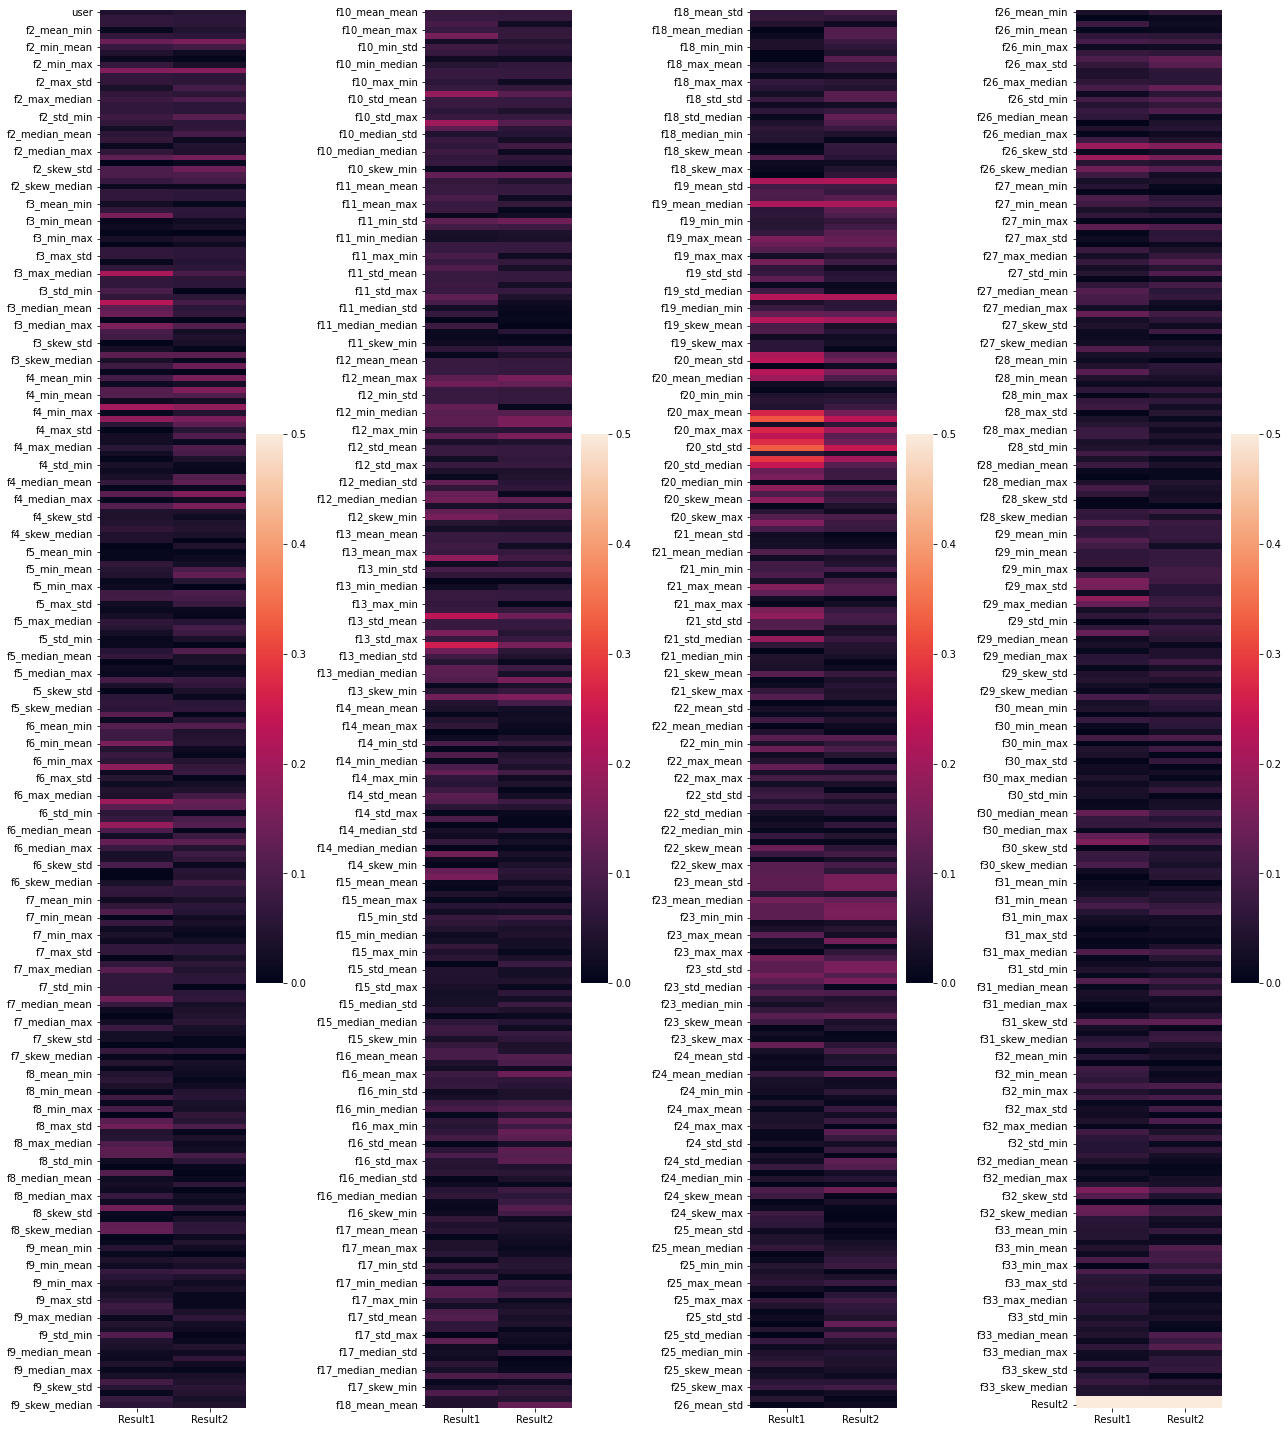

In [8]:
#calculate correlation matrix and store correlations between features and the two SF26 measures (Result1 and Result2)
correlation = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1','Result2']]

#display correlations in number of seperate heatmaps for just Result1 and Result2 to make is easier to view
NUM_SUBPLOTS = 4
fig, axes = plt.subplots(1, NUM_SUBPLOTS, figsize=(18,20))

#for each subplot, plot a segment of the correlation matrix
for i in range(0,NUM_SUBPLOTS):
    sns.heatmap(ax=axes[i],data=correlation.iloc[int(correlation.shape[0]/NUM_SUBPLOTS)*i:int(correlation.shape[0]/NUM_SUBPLOTS)*(i+1),:].abs(),vmin=0, vmax=0.5)

fig.tight_layout()
plt.show()

### Top 10 Correlations between Result1 (Physical Component Score) and different motion features

In [9]:
topCorrelationsResult1 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result1']].sort_values('Result1',ascending=False).head(10)
topCorrelationsResult1.T

,Result1,Result2,f20_std_std,f20_max_std,f20_std_max,f20_std_mean,f20_max_max,f20_max_mean,f13_std_median,f20_std_median
Result1,1.0,0.695178,0.330391,0.321754,0.290286,0.27917,0.26927,0.26808,0.255613,0.241638


### Top 10 Correlations between Result2 (Mental Component Score) and different motion features

In [10]:
topCorrelationsResult2 = summaryMotionQS.drop(['Q' + str(x) for x in range(1,37)],axis=1).corr()[['Result2']].sort_values('Result2',ascending=False).head(10)
topCorrelationsResult2.T

,Result2,Result1,f20_std_std,Age,f20_max_std,f19_median_mean,f19_mean_mean,f19_mean_median,f20_max_max,f20_std_max
Result2,1.0,0.695178,0.244054,0.242317,0.231653,0.217859,0.215533,0.20952,0.206479,0.203762


## Visual analysis of correleation between Result1/Result2 and top 10 correlating features

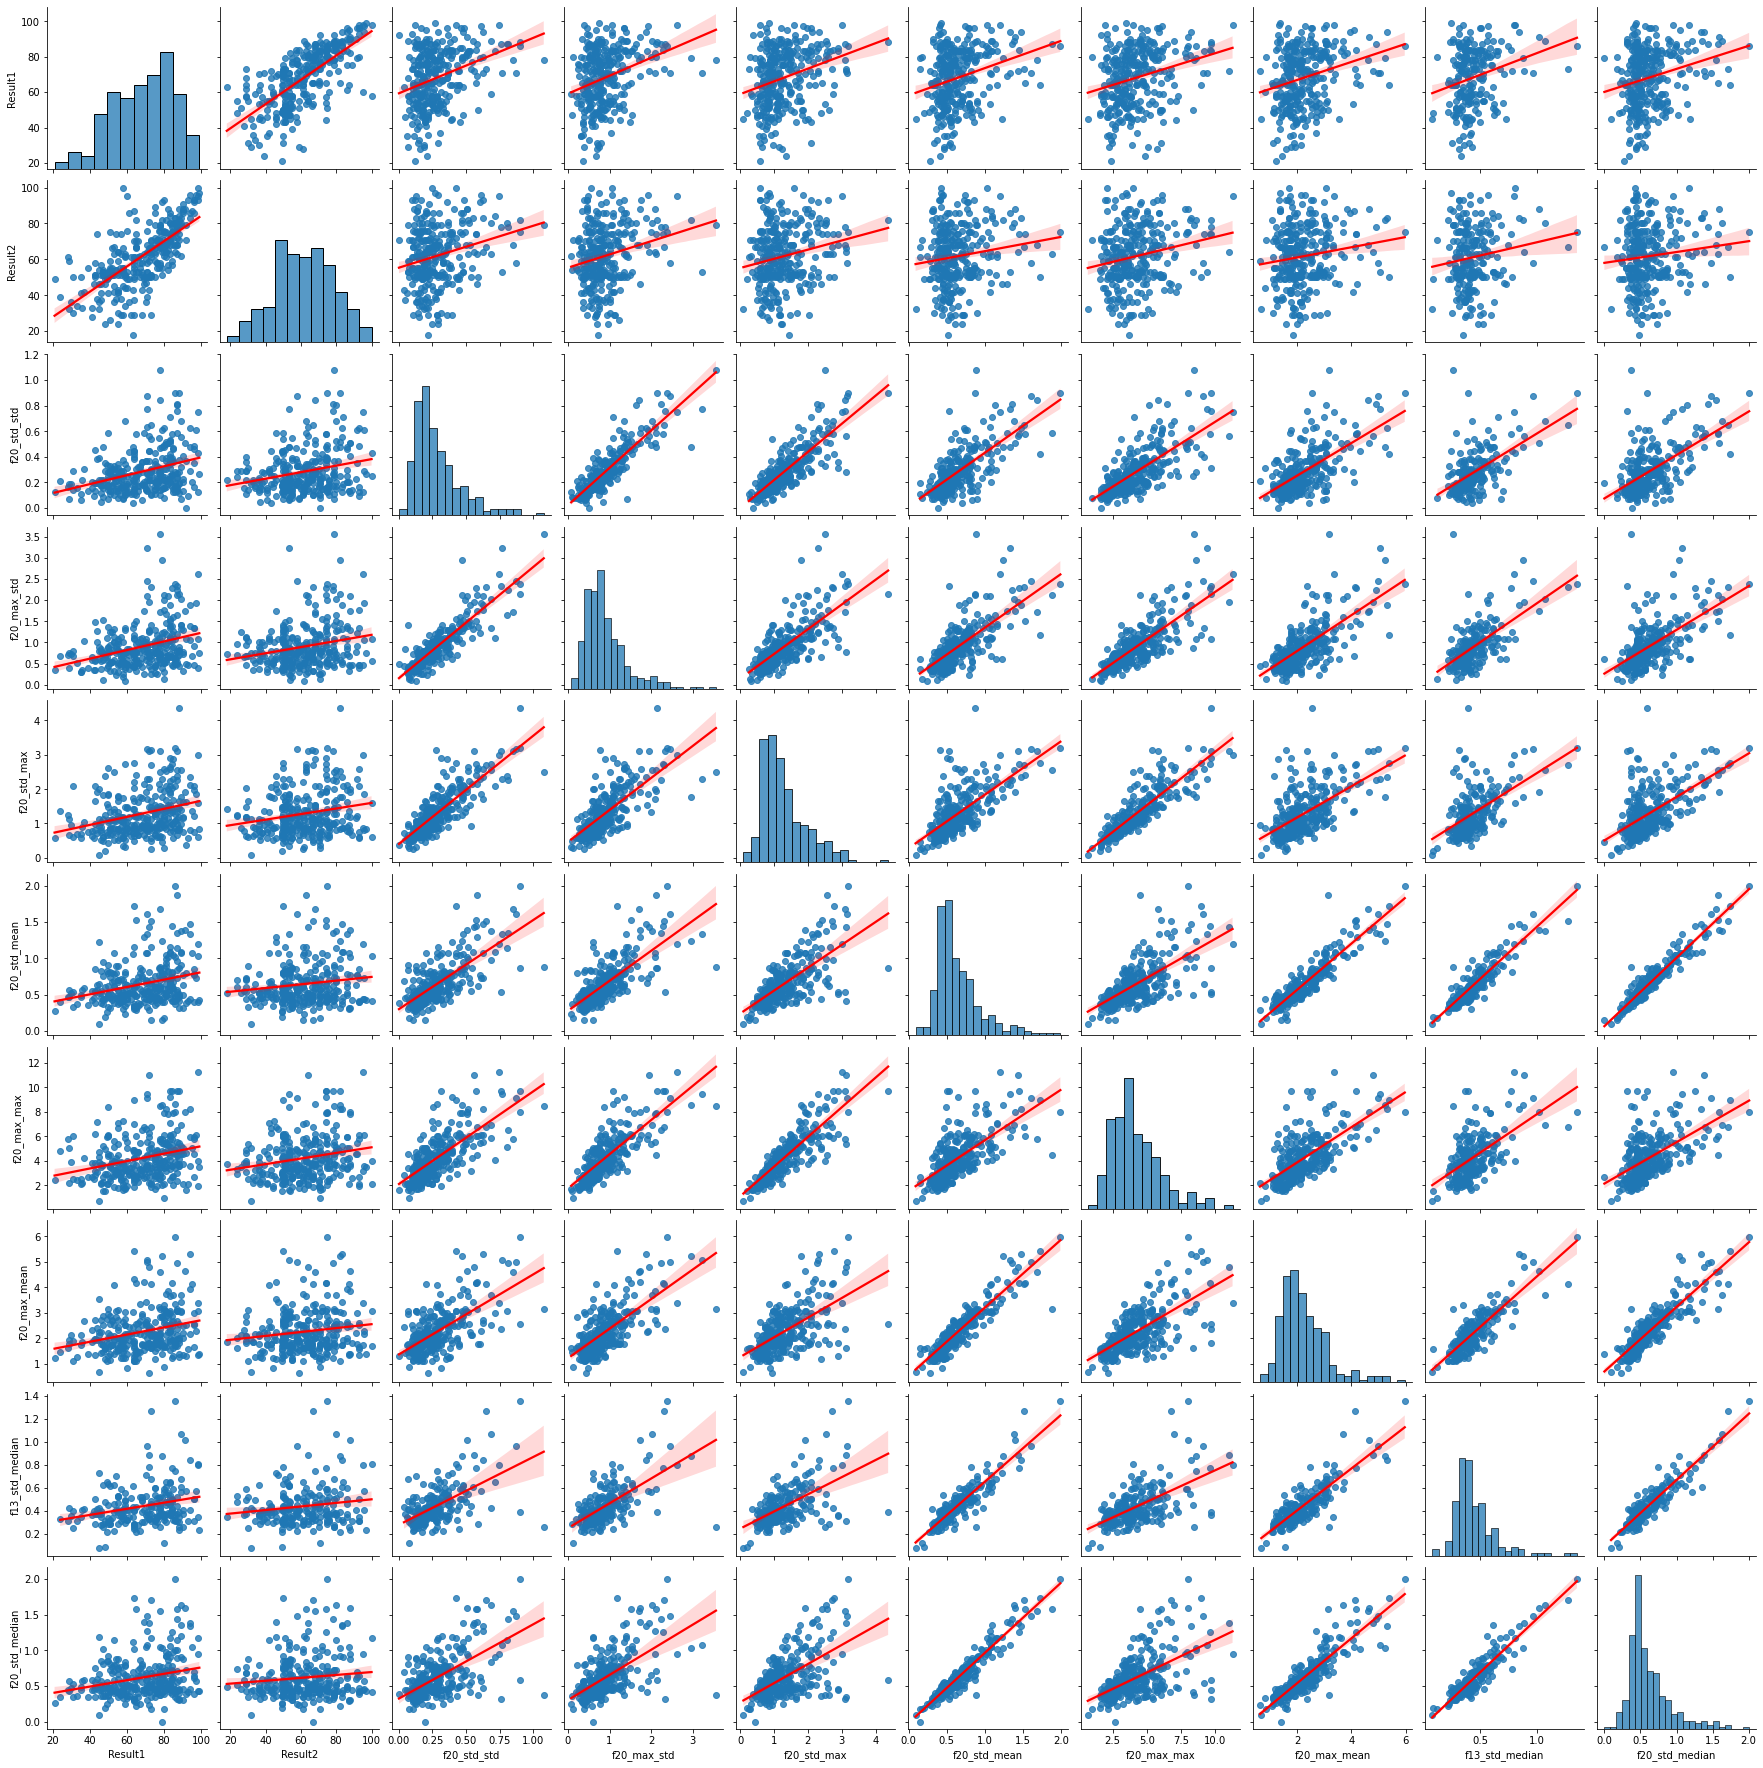

In [11]:
sns.pairplot(summaryMotionQS[topCorrelationsResult1.index.values.tolist()],kind="reg", plot_kws={'line_kws':{'color':'red'}})